In [94]:
import pandas as pd
import os, time, csv, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from collections import Counter
import pycountry

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [128]:
years = [i for i in range(2003, 2025)]
fontsize={'legend':12, 'text':8, 'labels':8, 'xticks':8}
colors = ["#808080", "k", "r", 'y', 'm', 'b', "#808080", "k", "r", 'y', 'm', 'b']

review_keywords = ['review', 'survey', 'overview', 'meta-analysis', 'systematic review', 
                   'state of the art', 'literature review', 'comparative analysis', 
                   'synthesis', 'bibliometric analysis']
                   
PATH = './results/'.replace('/', '\\')

uniform_article_types = {
    'Review Paper': 'Review Paper',
    'Review': 'Review Paper',
    'Conference Review': 'Review Paper',
    'Article': 'Research Article',
    'article': 'Research Article',
    'Journal Article': 'Research Article',
    'Conference Paper': 'Conference Paper',
    'conference':'Conference Paper',
    'Book Chapter': 'Book Chapter',
    'Research Article': 'Research Article',
    'research-article': 'Research Article',
    'review-article': 'Review Paper',
    'editorial': 'Editorial',
    'poster': 'Poster',
    'short-paper': 'Research Article',
    'survey': 'Survey Paper',
    'ORIGINAL ARTICLE': 'Research Article',
    'ORIGINAL PAPER': 'Research Article',
    'ORIGINAL RESEARCH': 'Research Article',
    'ORIGINAL RESEARCH PAPER': 'Research Article',
    'RESEARCH ARTICLE': 'Research Article',
    'REVIEW': 'Review Paper',
    'Research Articles': 'Research Article',
    'Review Article': 'Review Paper',
    'SPECIAL ISSUE ARTICLE': 'Special Issue Article',
    'SPECIAL ISSUE PAPER': 'Special Issue Paper',
    'SURVEY ARTICLE': 'Survey Paper',
    'none': 'None',
    'Volume: 4'                  :'Research Article',
    'Volume: 7'                  :'Research Article',
    'Volume: 9'                  :'Research Article',
    'Volume: 10'                 :'Research Article',
    'Volume: 11'                 :'Research Article',
    'Volume: 12'                 :'Research Article',
    'Volume: 10, Issue: 2'       :'Research Article',
    'Volume: 11, Issue: 1'       :'Research Article',
    'Volume: 11, Issue: 6'       :'Research Article',
    'Volume: 16, Issue: 8'       :'Research Article',
    'Volume: 18, Issue: 4'       :'Research Article',
    'Volume: 20, Issue: 2'       :'Research Article',
    'Volume: 20, Issue: 6'       :'Research Article',
    'Volume: 21, Issue: 2'       :'Research Article',
    'Volume: 21, Issue: 5'       :'Research Article',
    'Volume: 23, Issue: 4'       :'Research Article',
    'Volume: 24, Issue: 5'       :'Research Article',
    'Volume: 24, Issue: 7'       :'Research Article',
    'Volume: 70, Issue: 3'       :'Research Article',
    'Volume: 72, Issue: 7'       :'Research Article',
    'Volume: 10, Issue: 13'      :'Research Article',
    'Volume: 19, Issue: 18'      :'Research Article',
    'Volume: 19, Issue: 22'      :'Research Article',
    'Volume: 22, Issue: 10'      :'Research Article',
    'Volume: 22, Issue: 13'      :'Research Article',
    'Volume: 23, Issue: 15'      :'Research Article',
    'Volume: 24, Issue: 10'      :'Research Article',
    'Volume: 24, Issue: 15'      :'Research Article',
    'Volume: 37, Issue: 11'      :'Research Article',
    'Volume: 7, Issue: 10'       :'Research Article',
    'Volume: 8, Issue: 10'       :'Research Article',
    'Volume: 8, Issue: 14'       :'Research Article',
    'Volume: 9, Issue: 19'       :'Research Article',
    'Volume: 8, Issue: 4'        :'Research Article',
    'Volume: 9, Issue: 5'        :'Research Article',
    'Volume: 9, Issue: 6'        :'Research Article'
}

def subcategorybar(
    X, 
    vals, 
    colors, 
    labels, 
    markers='^', 
    width=0.8, 
    major=1000, 
    minor=500, 
    bar=True, 
    plot=False, 
    spines=False, 
    rotation=45,
    fontsize=fontsize,
    show_text=False,
    title=''
):
    n = len(vals)
    _X = np.arange(len(X))
    fig, ax = plt.subplots(figsize=(16, 5), dpi=250)
    for i in range(n):
        print(f"L: {labels[i]} | colors : {colors[i]} | {i} | {vals[i]}")
        if bar:
            bars = ax.bar(
                _X - width/2. + i/float(n)*width, 
                vals[i], 
                width=width/float(n), 
                align="edge",
                color=colors[i],
                label=labels[i]
            )   
            if show_text:
                for bar in bars:
                    yval = bar.get_height()
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,  # X position
                        yval + 0.1,  # Y position (slightly above the bar)
                        round(yval, 2),  # The value of the bar, rounded to 2 decimals
                        ha='center',  # Horizontal alignment
                        va='bottom',  # Vertical alignment
                        fontsize=fontsize['text']  # Font size
                    )
        if plot:
            print(markers)
            ax.plot(_X , vals[i], marker = markers[i], lw=0.45, color=colors[i], label=labels[i], mfc='none', markersize=5)
            plt.grid()

    plt.xticks(_X, X)
    
    ax.yaxis.set_minor_locator(MultipleLocator(minor))
    ax.set_xticks(range(0, len(X)), X, rotation=rotation, fontsize=fontsize['xticks'])
    ax.yaxis.set_major_locator(MultipleLocator(major))
    ax.spines[['right', 'top']].set_visible(spines)
    if len(title) != 0:
        ax.set_title(title)
    plt.legend(fontsize=fontsize['legend'])

def process_publish_date(df):
    for i in range(len(df.index)):
        temp = df.loc[i, 'publish_date']
        temp_datetime = pd.to_datetime(temp, format='%d %B %Y', errors='coerce')  # Try 'day Month year'

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='%Y-%m-%d', errors='coerce')  # Try 'YYYY-MM-DD'
            # print('YYYY-MM-DD')

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='Date of Publication: %d %B %Y', errors='coerce')  # Try 'Date of Publication: day Month year'

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='Date of Publication: %B %Y', errors='coerce')  # Try 'Date of Publication: Month year'

        # If successfully converted, update the dataframe
        if not pd.isnull(temp_datetime):
            df.loc[i, 'publish_date'] = temp_datetime

    df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')      
    return df

def filterDatetime(df):
    try:
        df['publish_date'] = pd.to_datetime(df['publish_date'], format='%d %B %Y', errors='coerce')
    except ValueError:
        df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d', errors='coerce')

    return df

def filterDataframe(df):
    for col in df.columns:
        df[col] = df[col].fillna('none')
    df = df.reset_index(drop=True)
    return df

def filterNumberOfAffiliation(affiliations_string):
    # Use regex to find all affiliations
    affiliations_list = re.findall(r'\((.*?)\)', affiliations_string)
    return len(affiliations_list)

def filterCountries(country_string):
    occurrences = country_string.split(',')
    found_countries = []

    for country in pycountry.countries:
        for occurrence in occurrences:
            if country.name in occurrence:
                found_countries.append(country.name)

    return ','.join(found_countries)

def is_review_paper(row):
    if 'conference' not in row['article_type'].lower():
        text = f"{row['title']} {row['keyword']} {row['abstract']}".lower()
        for word in review_keywords:
            if word in text:
                return 'Review Paper'
    return row['article_type']
def filterArticleType(df):
    df['article_type'] = df.apply(is_review_paper, axis=1)
    df['article_type'] = df['article_type'].replace(uniform_article_types)
    df['number_of_citation'] = df['number_of_citation'].replace({'none':0})
    df['number_of_citation'] = pd.to_numeric(df['number_of_citation'], errors='coerce')
    df['title'] = df['title'].astype('string') 
    df['article_type'] = df['article_type'].astype('string') 
    df['publisher'] = df['publisher'].astype('string') 
    df['keyword'] = df['keyword'].astype('string') 
    df['abstract'] = df['abstract'].astype('string') 
    df['publication_title'] = df['publication_title'].astype('string') 
    df['authors'] = df['authors'].astype('string') 
    df['affiliations'] = df['affiliations'].astype('string') 
    df['countries'] = df['countries'].astype('string') 
    df['number_of_countries'] = pd.to_numeric(df['number_of_countries'], errors='coerce')
    df['number_of_found_property_group'] = pd.to_numeric(df['number_of_found_property_group'], errors='coerce')
    df['number_of_found_properties'] = pd.to_numeric(df['number_of_found_properties'], errors='coerce')
    df['countries'] = df['countries'].apply(filterCountries)
    df['number_of_affiliations'] = df['affiliations'].apply(filterNumberOfAffiliation)
    df = df[df['countries'] != '']
    df = df.reset_index(drop=True)
    return df


def filterDataframe(df):
    for col in df.columns:
        df[col] = df[col].fillna('none')
    df = df.reset_index(drop=True)
    return df

df_solar = pd.read_excel('./solar panel.xlsx')
print(f'Before Solar: {len(df_solar)}')
df_solar = filterDataframe(df_solar)
df_solar = filterArticleType(df_solar)
df_solar = process_publish_date(df_solar)
df_solar['year'] = df_solar['publish_date'].dt.year
print(f'After Solar: {len(df_solar)}')
df_solar.to_excel('solar_filtered.xlsx')

df_generator = pd.read_excel('./generator.xlsx')
print(f'Before Generator: {len(df_generator)}')
df_generator = filterDataframe(df_generator)
df_generator = filterArticleType(df_generator)
df_generator = process_publish_date(df_generator)
df_generator['year'] = df_generator['publish_date'].dt.year
print(f'After Generator: {len(df_generator)}')
df_generator.to_excel('generator_filtered.xlsx')

df_power = pd.read_excel('./power.xlsx')
print(f'Before Power: {len(df_power)}')
df_power = filterDataframe(df_power)
df_power = filterArticleType(df_power)
df_power = process_publish_date(df_power)
df_power['year'] = df_power['publish_date'].dt.year
print(f'After Power: {len(df_power)}')
df_power.to_excel('power_filtered.xlsx')


Before Solar: 28
After Solar: 18
Before Generator: 104
After Generator: 88
Before Power: 573
After Power: 544


In [123]:
print(f"Solar panel: {df_solar.article_type.unique()}")
print(f"Generator: {df_generator.article_type.unique()}")
print(f"Power: {df_power.article_type.unique()}")

Solar panel: <StringArray>
['Research Article', 'Review Paper', 'Conference Paper', 'Data Paper']
Length: 4, dtype: string
Generator: <StringArray>
['Research Article', 'Conference Paper', 'Review Paper', 'Book Chapter']
Length: 4, dtype: string
Power: <StringArray>
['Research Article',     'Review Paper', 'Conference Paper',
     'Book Chapter',        'Retracted',       'Data Paper']
Length: 6, dtype: string


L: Research Article | colors : #808080 | 0 | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 5, 2]
L: Review Paper | colors : k | 1 | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]
L: Conference Paper | colors : r | 2 | [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
L: Data Paper | colors : y | 3 | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


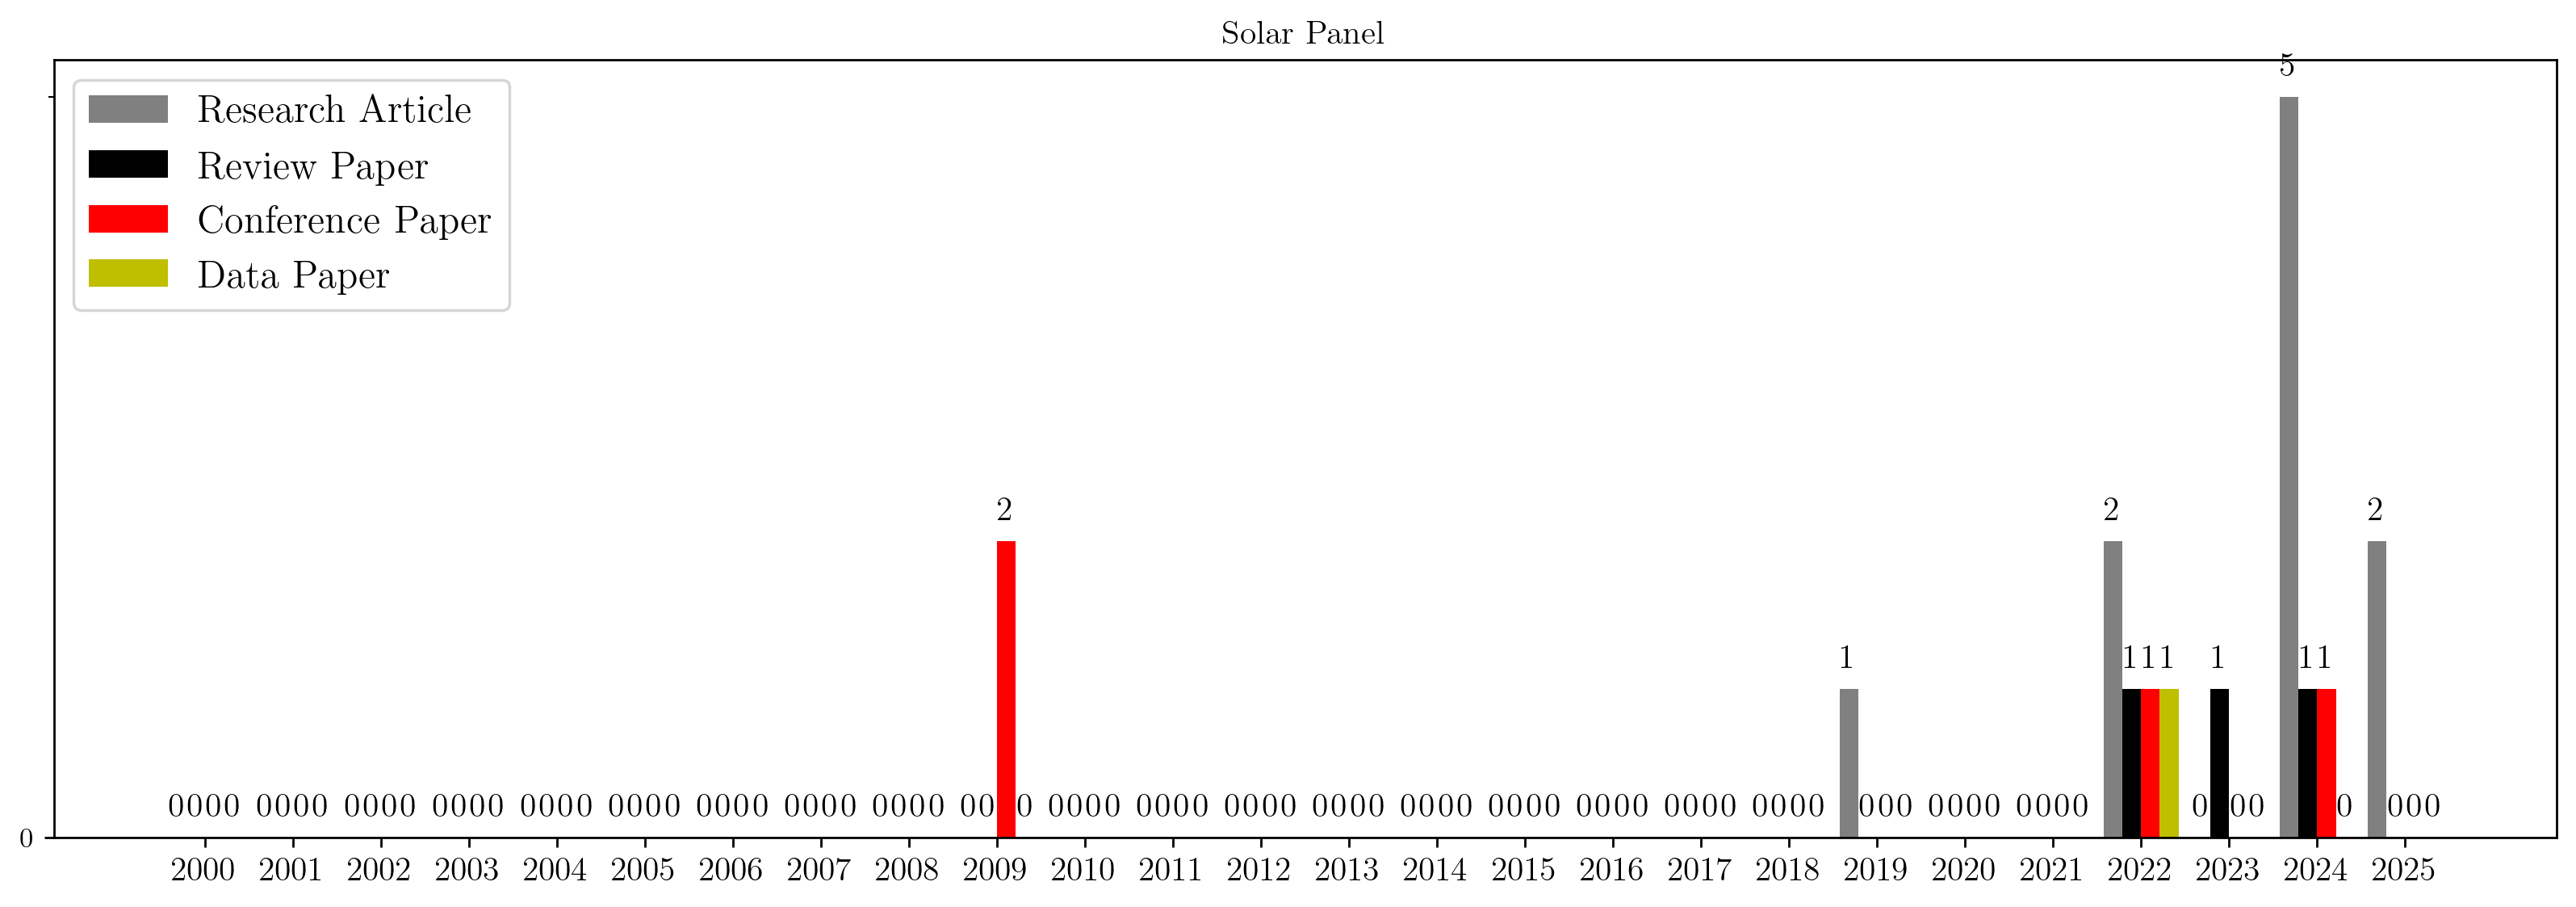

In [124]:
years = [i for i in range(2000, 2026)]
fontsize={'legend':14, 'text':12, 'labels':12, 'xticks':12}
article_types = df_solar.article_type.unique()
data_publication_over_year = {}
for article_type in article_types:
    data_publication_over_year[article_type] = []
    for year in years:
        temp = df_solar.loc[
            (df_solar['year'] == year) & (df_solar['article_type'] == article_type)]['title'].count()
        data_publication_over_year[article_type].append(temp)

subcategorybar(
    years, 
    [data_publication_over_year[article_type] for article_type in data_publication_over_year.keys()], 
    colors, 
    article_types,
    width=0.85, 
    major=25, 
    minor=5, 
    bar=True, 
    spines=True,
    show_text=True,
    rotation=0,
    fontsize=fontsize,
    title='Solar Panel'
)

L: Research Article | colors : #808080 | 0 | [0, 1, 4, 2, 6, 13, 27]
L: Conference Paper | colors : k | 1 | [0, 2, 0, 2, 6, 14, 8]
L: Review Paper | colors : r | 2 | [0, 0, 0, 0, 0, 1, 0]
L: Book Chapter | colors : y | 3 | [0, 0, 0, 0, 0, 1, 0]


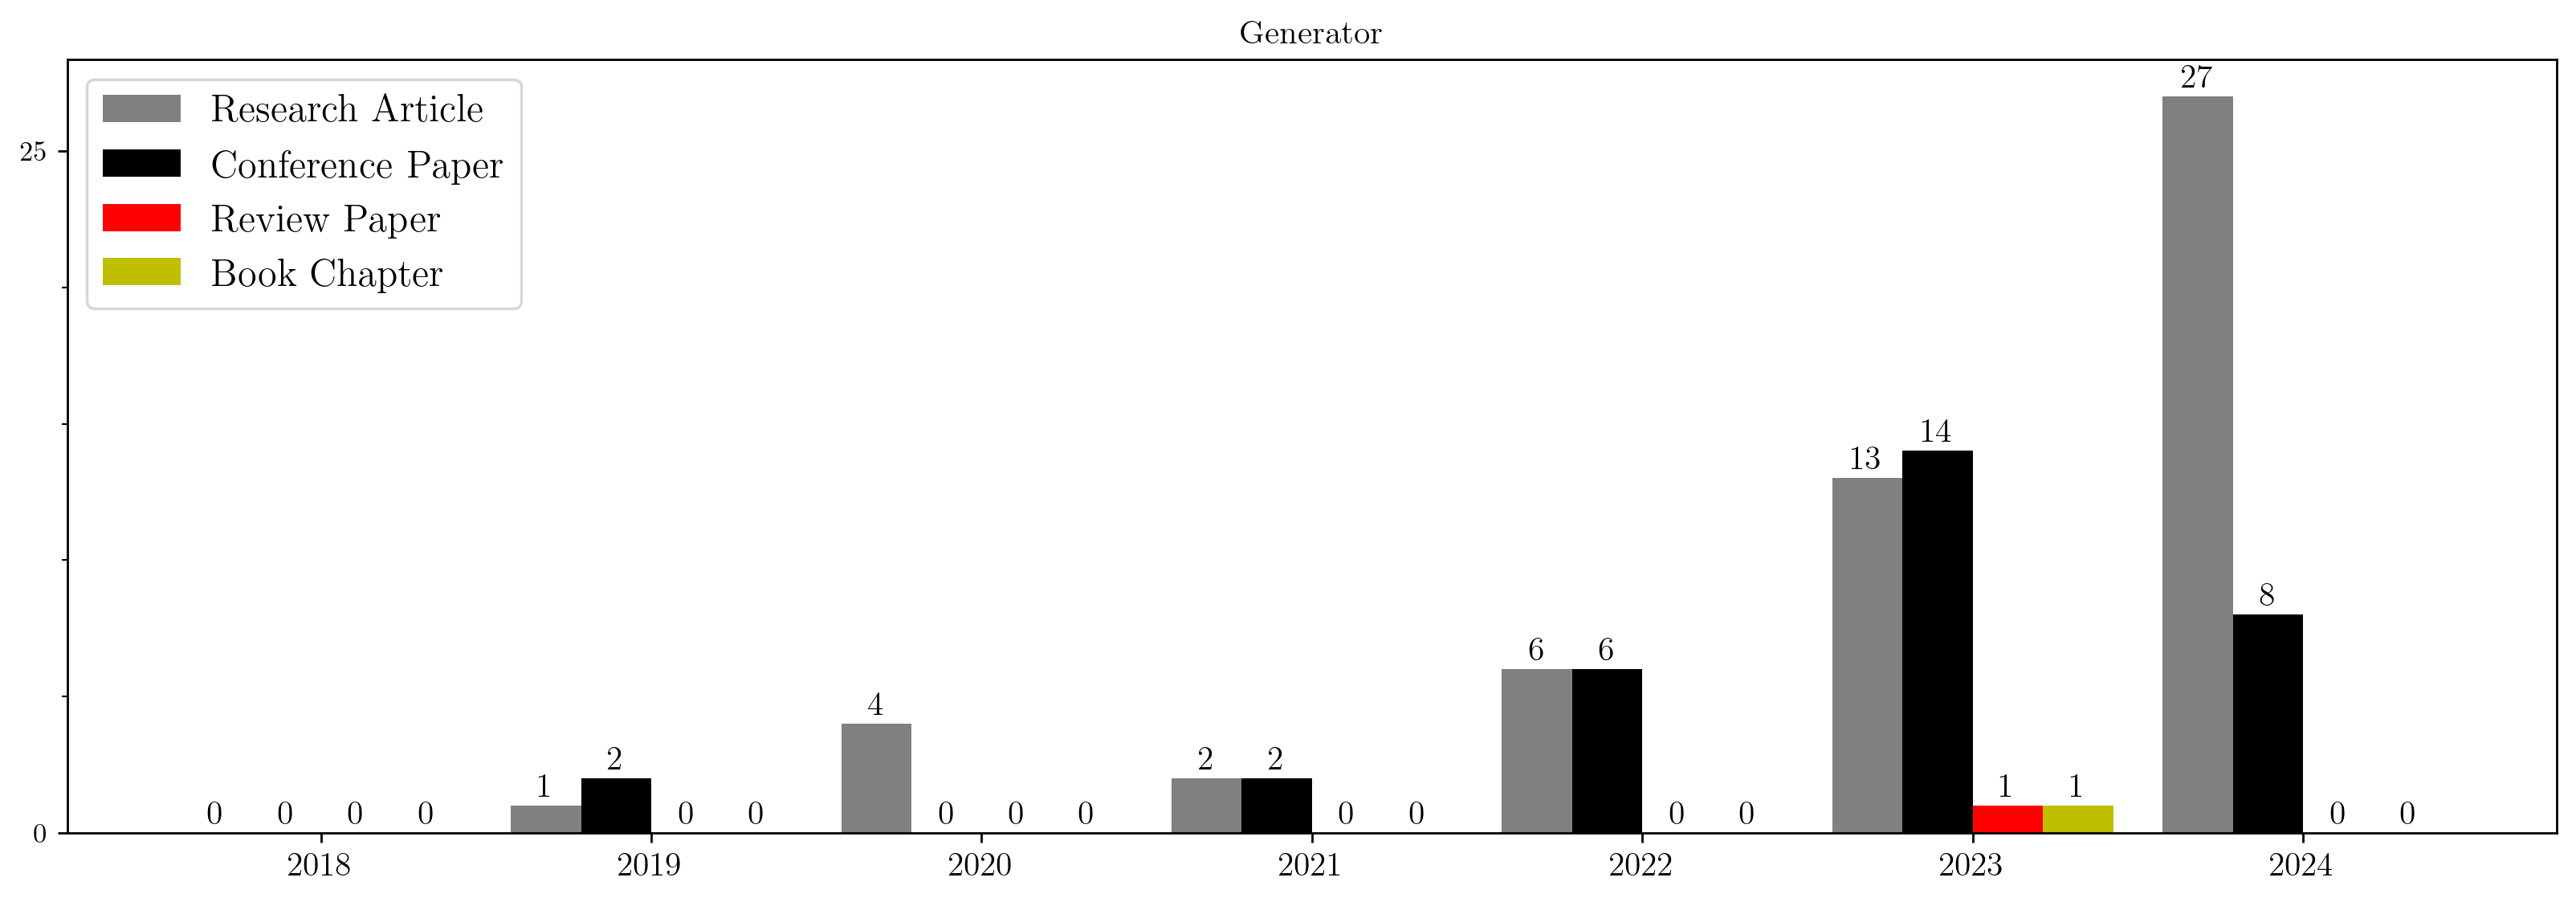

In [125]:
years = [i for i in range(2018, 2025)]
fontsize={'legend':14, 'text':12, 'labels':12, 'xticks':12}
article_types = df_generator.article_type.unique()
data_publication_over_year = {}
for article_type in article_types:
    data_publication_over_year[article_type] = []
    for year in years:
        temp = df_generator.loc[
            (df_generator['year'] == year) & (df_generator['article_type'] == article_type)]['title'].count()
        data_publication_over_year[article_type].append(temp)

subcategorybar(
    years, 
    [data_publication_over_year[article_type] for article_type in data_publication_over_year.keys()], 
    colors, 
    article_types,
    width=0.85, 
    major=25, 
    minor=5, 
    bar=True, 
    spines=True,
    show_text=True,
    rotation=0,
    fontsize=fontsize,
    title='Generator'
)

L: Research Article | colors : #808080 | 0 | [0, 4, 6, 26, 48, 71, 163]
L: Review Paper | colors : k | 1 | [0, 0, 1, 0, 5, 8, 15]
L: Conference Paper | colors : r | 2 | [1, 2, 3, 18, 36, 56, 62]
L: Book Chapter | colors : y | 3 | [0, 0, 0, 0, 1, 1, 2]
L: Retracted | colors : m | 4 | [0, 0, 0, 0, 1, 0, 0]
L: Data Paper | colors : b | 5 | [0, 0, 0, 0, 1, 0, 0]


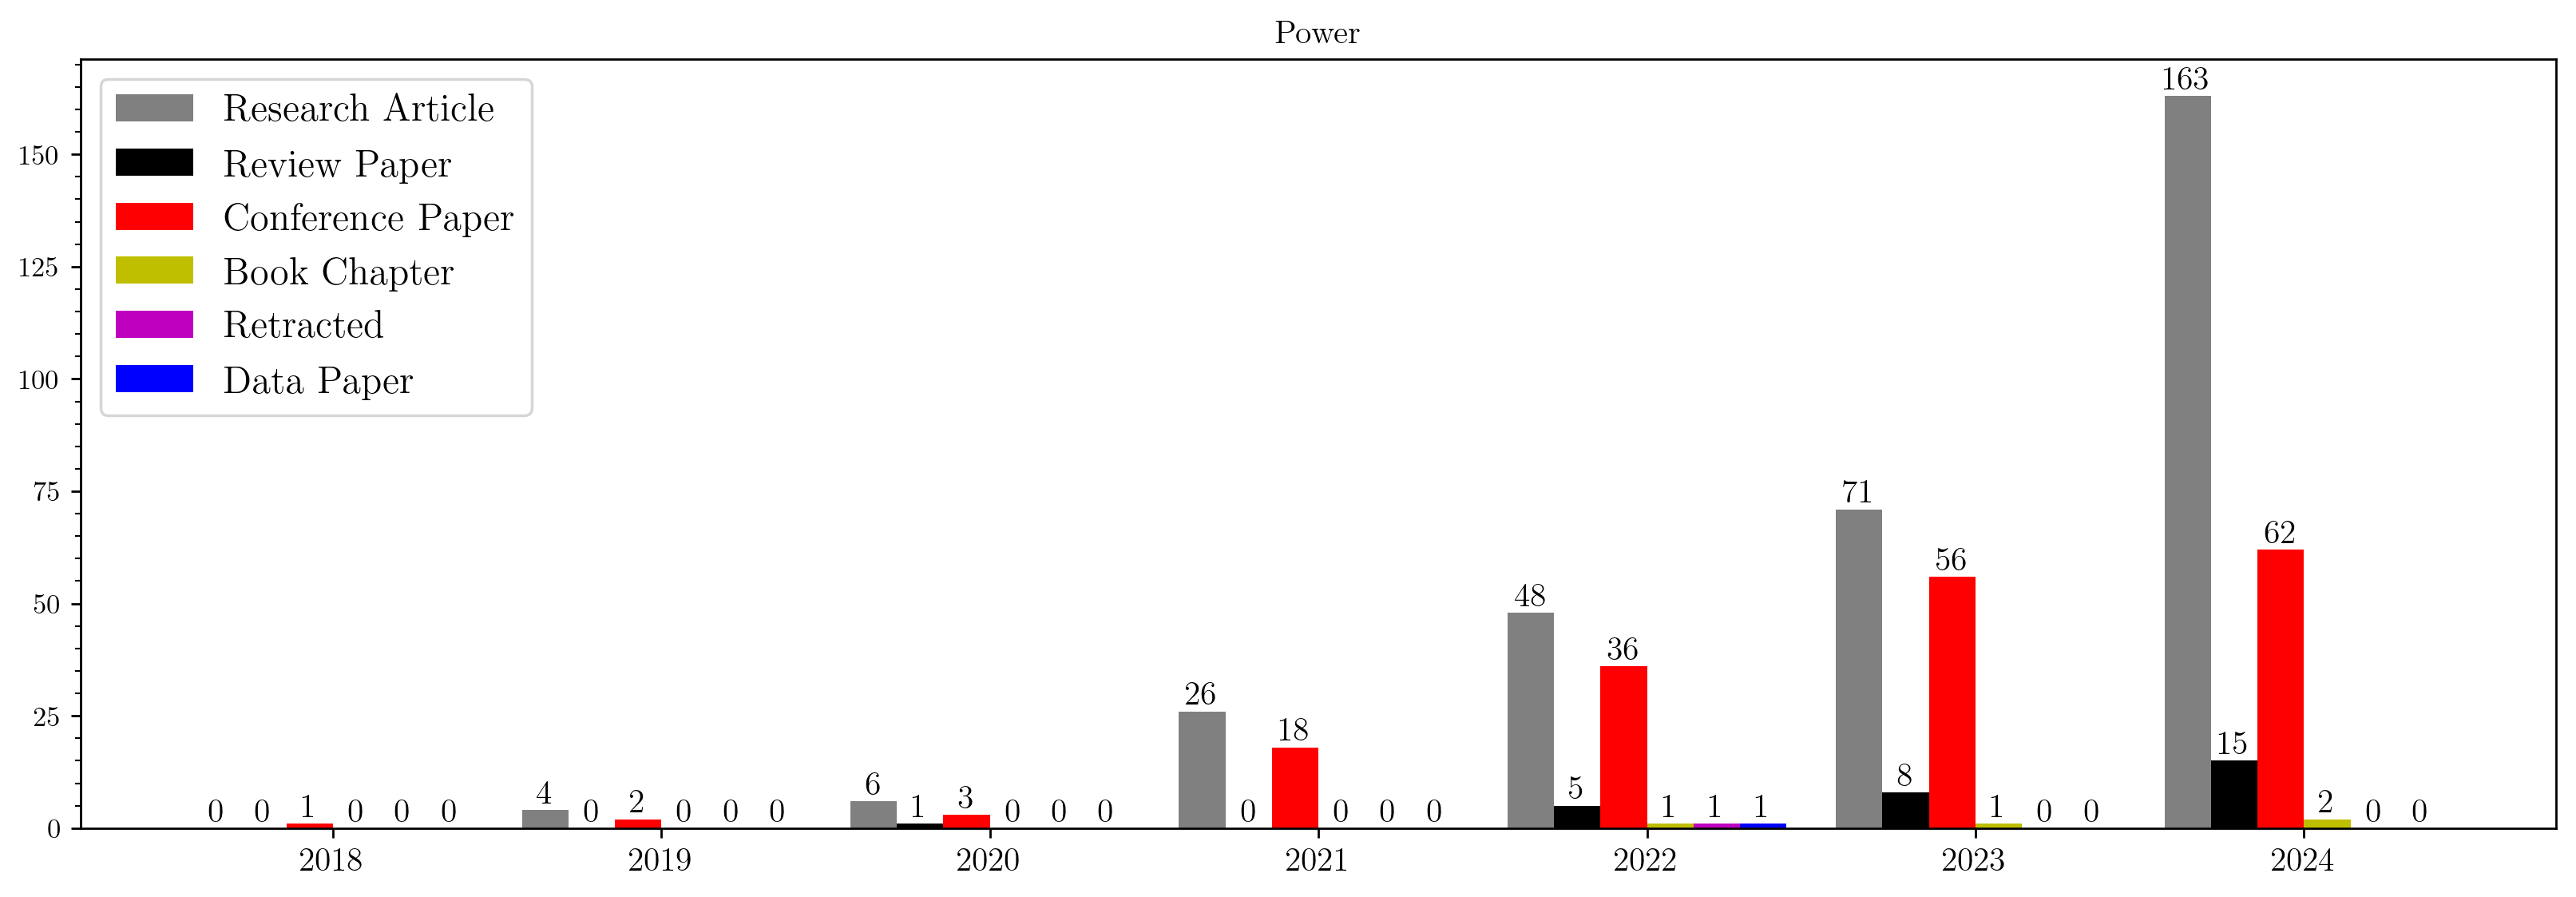

In [126]:
years = [i for i in range(2018, 2025)]
fontsize={'legend':14, 'text':12, 'labels':12, 'xticks':12}
article_types = df_power.article_type.unique()
data_publication_over_year = {}
for article_type in article_types:
    data_publication_over_year[article_type] = []
    for year in years:
        temp = df_power.loc[
            (df_power['year'] == year) & (df_power['article_type'] == article_type)]['title'].count()
        data_publication_over_year[article_type].append(temp)

subcategorybar(
    years, 
    [data_publication_over_year[article_type] for article_type in data_publication_over_year.keys()], 
    colors, 
    article_types,
    width=0.85, 
    major=25, 
    minor=5, 
    bar=True, 
    spines=True,
    show_text=True,
    rotation=0,
    fontsize=fontsize,
    title='Power'
)

C:\Users\user\AppData\Local\Temp\ipykernel_5512\414646948.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  property_frequency[prop] = df_combined_text.str.contains(prop, case=False).sum()


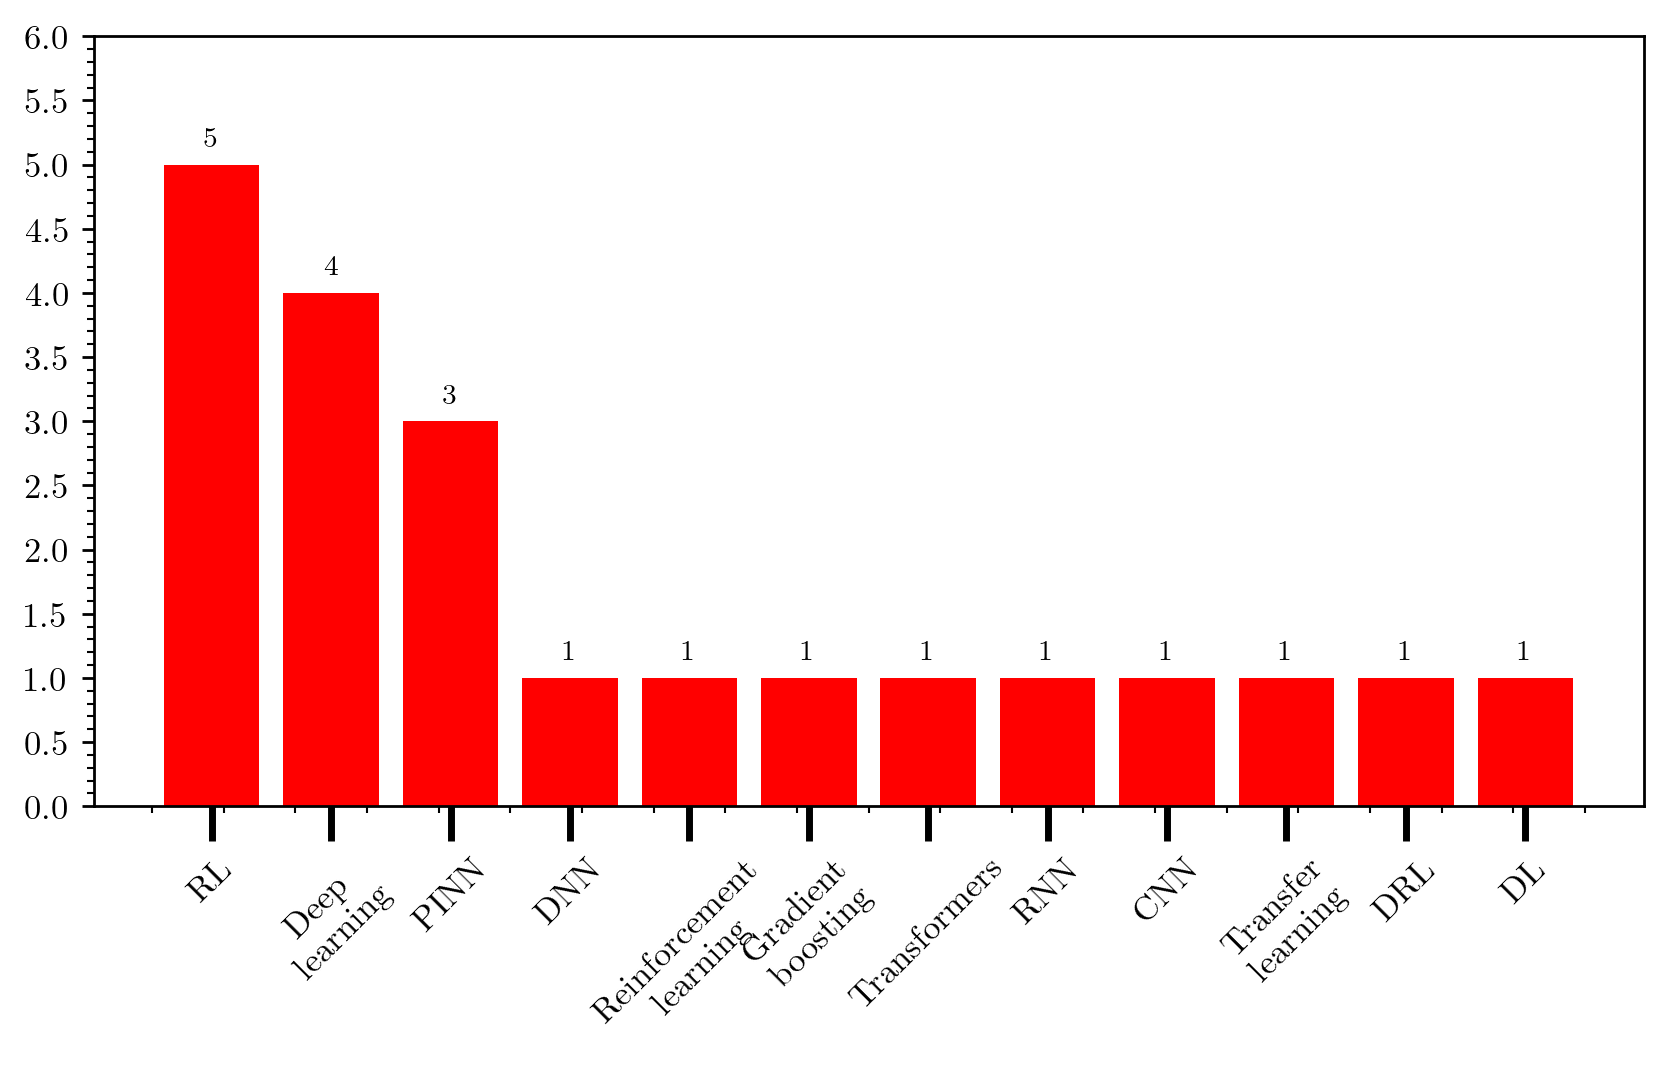

In [150]:
properties = [
    'DNN', 'RL', 'DRL', 'DL', 'Genetic Algorithm', 'LSTM', 'PINN', 'Physics-informed neural networks (PINN)', 'Neural operator', 'Fourier neural operator (FNO)', 'Gaussian processes', 'Reinforcement learning', 'Deep learning', 'Supervised learning', 'SVM' , 'CNN', 'RNN',
    'Unsupervised learning', 'Semi-supervised learning', 
    'Autoencoders', 'Variational autoencoders (VAE)', 'Generative adversarial networks (GAN)',
    'Bayesian neural networks', 'Sparse regression', 'Symbolic regression',
    'Support vector machines (SVM)', 'Random forests', 'Gradient boosting',
    'Physics-constrained optimization',
    'Multi-task learning', 'Transfer learning', 'Meta-learning', 
    'Convolutional neural networks (CNN)', 'Recurrent neural networks (RNN)',
    'Long short-term memory (LSTM)', 'Transformers', 'Graph neural networks (GNN)',
    'Physics-guided loss functions', 'Regularization methods', 'Optimization algorithms',
    'Hyperparameter tuning', 'Monte Carlo methods', 'Markov chain Monte Carlo (MCMC)',
    'Probabilistic programming', 'Reinforcement learning for physical systems', 
    'Model-based reinforcement learning', 'Evolutionary algorithms',
    'Bayesian optimization', 'Differentiable programming', 
    'Hybrid neural-symbolic learning', 'Active learning'
]

property_frequency = {prop: 0 for prop in properties}

df = df_solar
df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)
for prop in properties:
    property_frequency[prop] = df_combined_text.str.contains(prop, case=False).sum()

# Convert the dictionary into a pandas DataFrame for easier plotting
property_df = pd.DataFrame(list(property_frequency.items()), columns=['Property', 'Frequency'])
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Create the bar plot with sorted frequencies
fig, ax = plt.subplots(figsize=(8, 4), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=fontsize['text']  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set up the y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=10, rotation=45)
ax.set_xticks(range(len(property_df['Property'])))  # Major ticks
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

ax.set_ylim([0, 6])
# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_5512\1812225157.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  property_frequency[prop] = df_combined_text.str.contains(prop, case=False).sum()


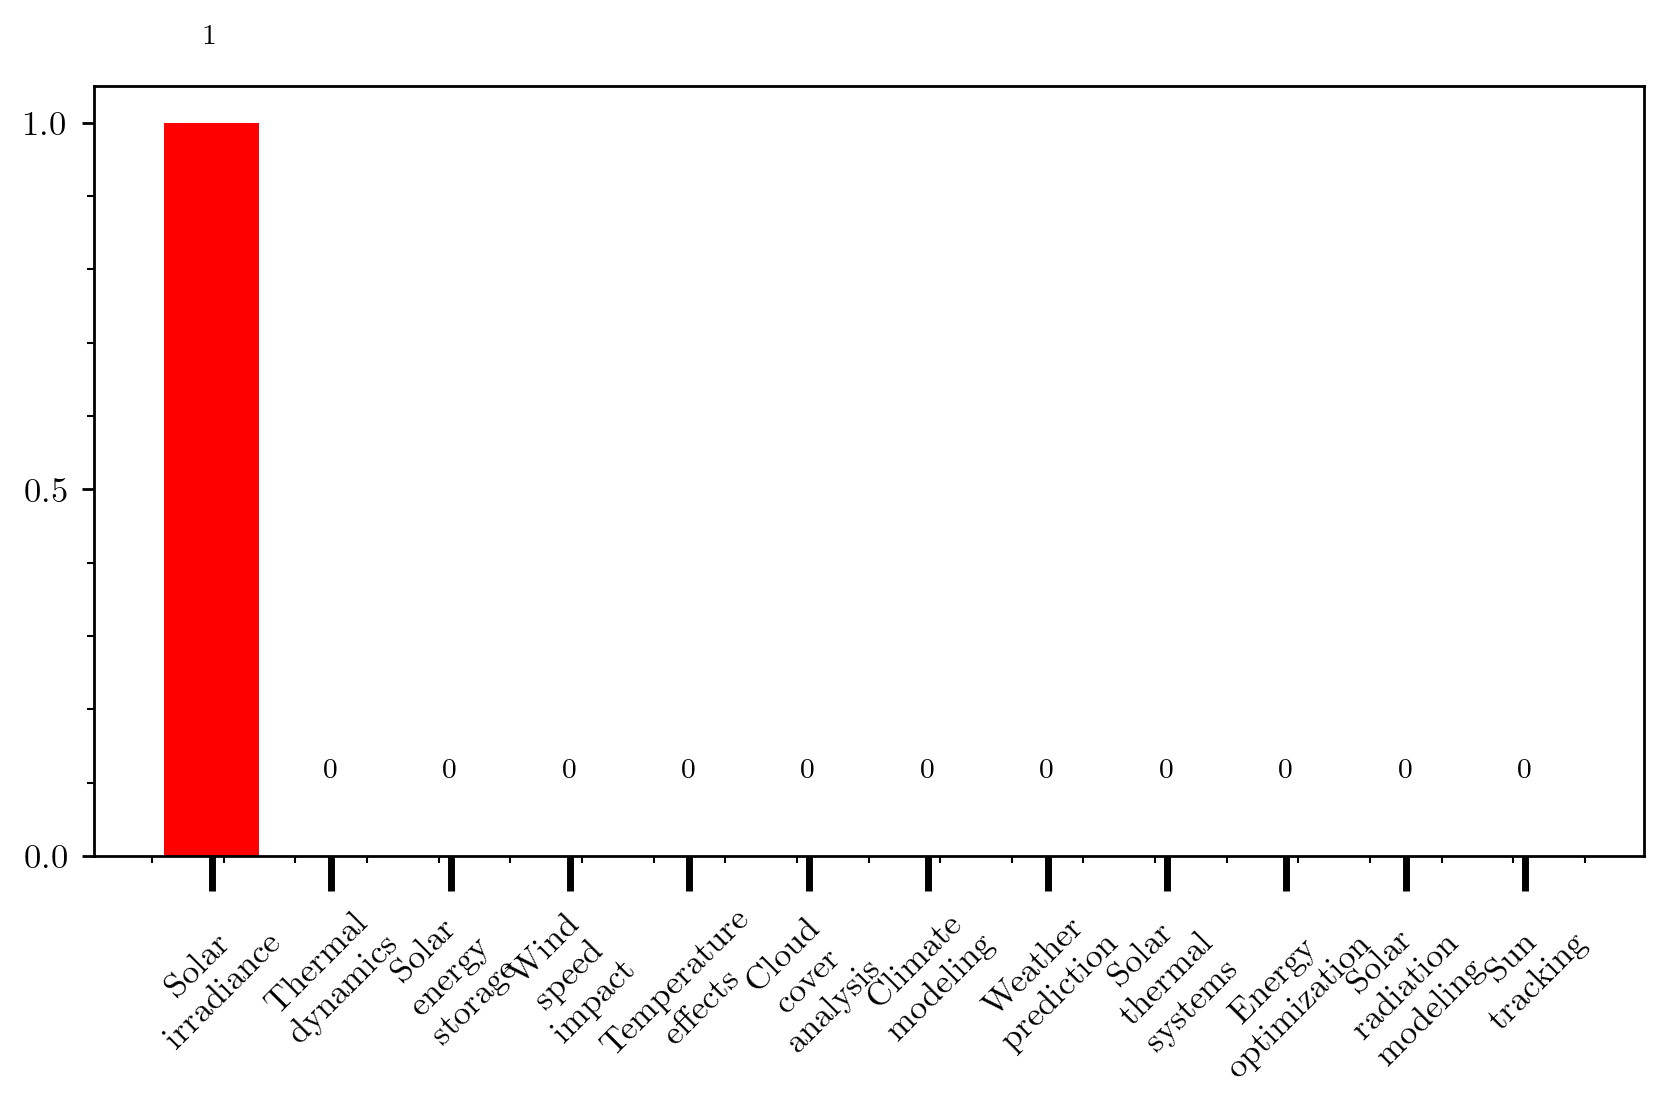

In [152]:
properties = [
    'Thermal dynamics', 'Heat transfer', 
    'Renewable energy modeling', 'Hybrid modeling',
     'Solar panel efficiency', 'Photovoltaics', 'Solar irradiance', 
    'Solar forecasting', 'Energy conversion efficiency', 
    'Maximum power point tracking (MPPT)', 'Solar power prediction', 
    'Sun tracking', 'Solar energy storage', 'Solar radiation modeling',
    'Energy optimization', 'Solar thermal systems','Weather prediction', 'Climate modeling', 'Cloud cover analysis',
    'Temperature effects', 'Wind speed impact', 'Seasonal variations'
]

property_frequency = {prop: 0 for prop in properties}

df = df_solar
df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)
for prop in properties:
    property_frequency[prop] = df_combined_text.str.contains(prop, case=False).sum()

# Convert the dictionary into a pandas DataFrame for easier plotting
property_df = pd.DataFrame(list(property_frequency.items()), columns=['Property', 'Frequency'])
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Create the bar plot with sorted frequencies
fig, ax = plt.subplots(figsize=(8, 4), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=fontsize['text']  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set up the y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=10, rotation=45)
ax.set_xticks(range(len(property_df['Property'])))  # Major ticks
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# ax.set_ylim([0, 6])
# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()